In [1]:
from __future__ import division, print_function # python3 compatibilty
import pymc3 as pm
import numpy
import pandas as pd
import numpy as np                  # import numpy
from time import time               # use for timing functions
import matplotlib.gridspec as gridspec
from scipy import stats
#from matplotlib import pyplot as pl # import pyplot from matplotlib
import matplotlib.pyplot as plt

rcparams = {}
rcparams['text.usetex'] = True
rcparams['axes.linewidth'] = 0.7
rcparams['font.family'] = 'sans-serif'
rcparams['font.size'] = 22

from matplotlib import rc
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
from sklearn.metrics import mean_squared_error, r2_score
import arviz as az

# functions for plotting posteriors
import scipy
import corner
from scipy.stats import gaussian_kde
import os

In [2]:
#read the data
os.chdir('/Users/krishna/Documents/phd_work/SNe_data_analy/checks')

df = pd.read_csv('data_shoes.csv')
#df = df.drop([4, 16])
SN_ceph = df['SN_name'].to_numpy()
host = df['host'].to_numpy()
mu_ceph = df['mu_ceph'].to_numpy()
e_mu = df['e_mu'].to_numpy()
bmax = df['Bmax'].to_numpy()
ebmax = df['eBmax'].to_numpy()
vmax = df['Vmax'].to_numpy()
evmax = df['eVmax'].to_numpy()
st = df['stretch'].to_numpy()
est = df['err_stretch'].to_numpy()
color = df['color'].to_numpy()
ecolor = df ['e_color'].to_numpy()
log_M = df['log_Mass'].to_numpy()
e_logM = df['e_logMass'].to_numpy()

#display(df)
print(len(SN_ceph))

#Lowzhflow_maxmodel_st
dff = pd.read_csv('data_lowz_HM.csv')
#df_cos = pd.read_csv('data_lowz_HM.csv')
df_cos = dff.loc[(dff['redshift'] > 0.02) & (dff['redshift'] < 0.15)]
SN_name = df_cos['SN_name'].to_numpy()
Bmax = df_cos['Bmax'].to_numpy()
eBmax = df_cos['eBmax'].to_numpy()
Vmax = df_cos['Vmax'].to_numpy()
eVmax = df_cos['eVmax'].to_numpy()
s = df_cos['stretch'].to_numpy()
es = df_cos['err_stretch'].to_numpy()
ebv = df_cos['color'].to_numpy()
eEBV = df_cos['e_color'].to_numpy()
# logM = df_cos['log_Mass'].to_numpy()
# elogM = df_cos['e_logMass'].to_numpy()
z = df_cos['redshift'].to_numpy()
print(len(z))

19
96


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigcos, sigcal, H0, R, P1, P0]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:48<00:00, 497.85draws/s]


Time taken to run 'PyMC3' is 60.38631796836853 seconds
          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
P0     -19.164  0.048 -19.257  -19.075      0.001    0.000    7280.0   7280.0   
P1      -0.969  0.113  -1.184   -0.757      0.001    0.001   11759.0  11759.0   
R        2.147  0.166   1.839    2.465      0.002    0.001   10791.0  10791.0   
H0      72.684  1.731  69.519   76.003      0.020    0.014    7572.0   7533.0   
sigcal   0.178  0.040   0.113    0.258      0.000    0.000    9549.0   8532.0   
sigcos   0.145  0.016   0.117    0.177      0.000    0.000   11506.0  11224.0   

        ess_bulk  ess_tail  r_hat  
P0        7322.0    6422.0    1.0  
P1       11820.0    7996.0    1.0  
R        10762.0    7521.0    1.0  
H0        7610.0    6712.0    1.0  
sigcal   10118.0    7930.0    1.0  
sigcos   11585.0    7719.0    1.0  


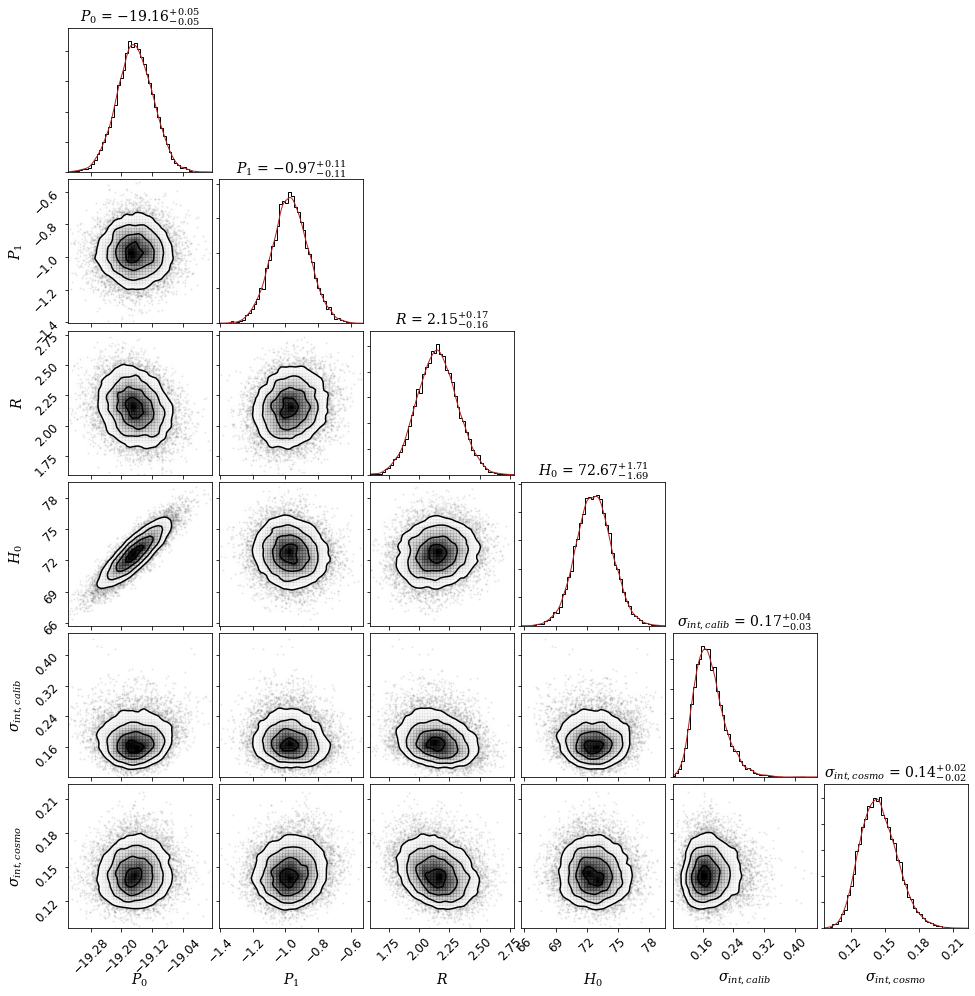

In [3]:
with pm.Model():
    P_0 = pm.Uniform('P0', lower = -30, upper = 30)
    P_1 = pm.Uniform('P1', lower = -5, upper = 5)
    R = pm.Uniform('R', lower = 0, upper = 15)
    H0 = pm.Uniform('H0', lower = 60, upper = 80)
    sigma_calib = pm.HalfCauchy('sigcal', 5)
    sigma_cosmo =  pm.HalfCauchy('sigcos', 5)
    
    c = 299792.458
    q0 = -0.55
    j0 = 1
    
    
    mu0 = P_0 + P_1*(st-1) + R*(color) + mu_ceph
    
    mu1 = P_0 + P_1*(s-1) + R*(ebv) + 5*np.log10((c*z/H0)*(1 + 1/2*(1- q0)*z - 1/6*(1- q0 - 3*q0**2 + j0)*z**2)) + 25
  
    
    sigma0 = np.sqrt(ebmax ** 2 + sigma_calib**2 + e_mu**2 + (P_1*est)**2 +
                    R**2*(ebmax**2 + evmax**2) - 2*R*ebmax**2)
    
    sigma1 = np.sqrt(eBmax ** 2 + sigma_cosmo**2 + (P_1*es)**2 +
                    R**2*(eBmax**2 + eVmax**2) - 2*R*eBmax**2)
    
    #m_B = pm.Normal('m_B', mu=y_est, sd = sigma, observed=mb)
    results0 = pm.Normal('results0', mu0, sigma0, observed = bmax)
    results1 = pm.Normal('results1', mu1, sigma1, observed = Bmax)
    # This line is constructing the likelihood for me taking mu, model, and sigma
    
    
    Nsamples = 3000  # final number of samples
    Ntune = 3000  # number of tuning samples

    # perform sampling
    t0 = time()
    trace = pm.sample(Nsamples, tune=Ntune, discard_tuned_samples=True, cores=4,target_accept=0.9);  # perform sampling
    t1 = time()
    timepymc3 = (t1-t0)
    print("Time taken to run 'PyMC3' is {} seconds".format(timepymc3))
    plt.rcParams.update({'font.size': 12})
    #pm.traceplot(trace) 
    print(pm.summary(trace))
#------------------------------------------------------------------------
#Function to plot corner plots
    
def plotposts(samples):    
    fig = corner.corner(samples, bins = 50, labels=[r'$P_0$', r'$P_1$', r'$R$', r'$H_0$', r'$\sigma_{int,calib}$', r'$\sigma_{int,cosmo}$'], 
                        color = 'black',
                        show_titles=True,
                        hist_kwargs={'density': True}, smooth = True, title_kwargs={"fontsize": 14},
                        label_kwargs={"fontsize": 14})


        # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 7, 14, 21, 28, 35], samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick', lw = 1)
    fig = plt.gcf() # to get the current figure...
    #fig.savefig("SHOES_noHM_corner_18thJUne.pdf",dpi = 500, bbox_inches='tight', pad_inches=0.2)

#plt.rcParams.update({'font.size': 16}) # reset the font size
samples_pymc3 = np.vstack((trace['P0'], trace['P1'], trace['R'], trace['H0'], trace['sigcal'], trace['sigcos'])).T
plotposts(samples_pymc3)

In [9]:
#fit params
means = pm.summary(trace)['mean'].values
sds = pm.summary(trace)['sd'].values
p0, ep0 = means[0], sds[0]
p1, ep1 = means[1], sds[1]
r, er = means[2], sds[2]
sig = means[4]

# ypred = p0 + p1*(s-1) + r*(ebv) + 5*np.log10((c*z/H0)*(1 + 1/2*(1- q0)*z - 1/6*(1- q0 - 3*q0**2 + j0)*z**2)) + 25
# ytrue = Bmax
# pm.r2_score(ytrue, ypred)

In [6]:
#calculate mu
def mu_HM(st, mB, mV, P0, P1, R, est, emB, eEBV, eP0, eP1 , eR, dSN):   #alp = alpha

    mu_i = mB - P0 - P1*(st - 1.) - R*(mB-mV)    # calculate the distance modulus

    dmu_i = np.sqrt(emB ** 2 + eP0 ** 2 + ((st - 1.) * eP1) ** 2 + (P1*est)**2 + (eR * (mB - mV)) ** 2 
                + dSN ** 2 + (R*eEBV)**2) # calculate the error on \mu

    return mu_i, dmu_i

mu_shoes =[]
dmu =[]

for i in range(len(Bmax)):
    mu, sig_mu = mu_HM(s[i],Bmax[i], Vmax[i], p0, p1, r, es[i], eBmax[i], eEBV[i], ep0, ep1, er, sig)
    mu_shoes.append(mu)
    dmu.append(sig_mu)
    #mu_SBF = [round(elem, 3) for elem in mu_SBF]
    #sig_muSBF = [round(elem, 3) for elem in sig_muSBF]

dict = {'name': SN_name, 'mu': mu_shoes, 'err_mu': dmu}     
dist = pd.DataFrame(dict)
#dist.to_csv(os.getcwd()+'/Hierchichal_analysis/SHOES_cosmo.csv')

Mean squared error_st: 0.03
R2 Score_st: 0.16
Mean squared error_color: 0.03
R2 Score_color: 0.72


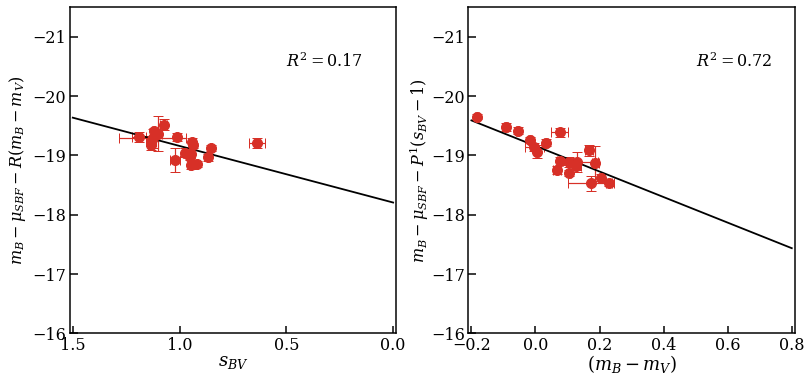

In [11]:
# R2 score and RMSE of the models
plt.rcParams['axes.xmargin'] = 0.01
plt.rcParams['axes.ymargin'] = 0.03
from sklearn.metrics import mean_squared_error, r2_score

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6))

#plot the relation
def bestfit(p0,p1,st):
    return p0 + p1*(st-1)

x = np.linspace(0., 1.5, 100)
fit1 = bestfit(p0, p1, x)
pred = bestfit(p0, p1, st)

Mb = []
Mb_err = []
for i in range(len(bmax)):
    M =  bmax[i] - mu_ceph[i] - r*(color[i])
    dM = np.sqrt(ebmax[i] ** 2 + e_mu[i]**2 + (r*ecolor[i])**2 + (er*color[i])**2)
    Mb.append(M)
    Mb_err.append(dM)

ax1.tick_params(axis='both',direction='in',labelsize=16)
ax1.xaxis.set_tick_params(which='major',width=1.5,length=7.5)
ax1.xaxis.set_tick_params(which='minor',width=1.5,length=4.5)
ax1.yaxis.set_tick_params(which='major',width=1.5,length=7.5)
ax1.yaxis.set_tick_params(which='minor',width=1.5,length=4.5)
ax1.spines['top'].set_linewidth(1.5)
ax1.spines['right'].set_linewidth(1.5)
ax1.spines['bottom'].set_linewidth(1.5)
ax1.spines['left'].set_linewidth(1.5)
ax1.xaxis.set_label_coords(0.5, -0.06)
ax1.tick_params(axis='both',direction='in',which='both')
plt.rc('font', family='serif')

ax1.errorbar(st , Mb , yerr = Mb_err, xerr = est, fmt = 'o',  mfc = '#d73027', mec = '#d73027', ecolor = '#d73027'
             , ms = 10, lw = 1.2, capsize = 5)
ax1.plot(x , fit1, color = 'black', lw = 1.8)
ax1.set_xlabel(r"$s_{BV}$", fontfamily = 'serif', fontsize = 18) 
ax1.set_ylabel(r"$m_B - \mu_{SBF} - R(m_B - m_V)$", fontfamily = 'serif', fontsize = 16)
ax1.invert_xaxis()
ax1.set_ylim(-16, -21.5)
ax1.text(0.5, -20.5, '$R^2 = 0.17$', fontfamily = 'serif', fontsize = 16)
print("Mean squared error_st: %.2f" % mean_squared_error(Mb,pred))
print("R2 Score_st: %.2f" % r2_score(Mb,pred))

def colorfit(p0 , R, col):
    return p0 + R*col

col = np.linspace(-0.2, 0.8, 100)
fit2 = colorfit(p0, r, col)
pred2 = colorfit(p0, r, color)

Mcol = []
Mcol_err = []
for i in range(len(bmax)):
    M = bmax[i] - mu_ceph[i] - p1*(st[i] - 1)
    dM = np.sqrt(ebmax[i]**2 + e_mu[i]**2 + (p1*est[i])**2 + (ep1*(st[i]-1))**2)
    Mcol.append(M)
    Mcol_err.append(dM)

ax2.tick_params(axis='both',direction='in',labelsize=16)
ax2.xaxis.set_tick_params(which='major',width=1.5,length=7.5)
ax2.xaxis.set_tick_params(which='minor',width=1.5,length=4.5)
ax2.yaxis.set_tick_params(which='major',width=1.5,length=7.5)
ax2.yaxis.set_tick_params(which='minor',width=1.5,length=4.5)
ax2.spines['top'].set_linewidth(1.5)
ax2.spines['right'].set_linewidth(1.5)
ax2.spines['bottom'].set_linewidth(1.5)
ax2.spines['left'].set_linewidth(1.5)
ax2.xaxis.set_label_coords(0.5, -0.06)
ax2.tick_params(axis='both',direction='in',which='both')
plt.rc('font', family='serif')

ax2.errorbar(color , Mcol, yerr = Mcol_err , xerr = ecolor, fmt = 'o',  mfc = '#d73027', mec = '#d73027', ecolor = '#d73027', 
             ms = 10, lw = 1.2, capsize = 5)
ax2.plot(col, fit2, color='black', lw = 1.8)
ax2.set_xlabel(r"$(m_B-m_V)$", fontfamily = 'serif', fontsize = 18) 
ax2.set_ylabel(r"$m_B - \mu_{SBF} - P^1(s_{BV} - 1)$", labelpad = 0, fontfamily = 'serif', fontsize = 16)
ax2.set_ylim(-16, -21.5)
ax2.text(0.5, -20.5, '$R^2 = 0.72$', fontfamily = 'serif', fontsize = 16)
print("Mean squared error_color: %.2f" % mean_squared_error(Mcol,pred2))
print("R2 Score_color: %.2f" % r2_score(Mcol,pred2))
#%matplotlib notebook
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.22)
plt.show()
fig.savefig(os.getcwd()+'/Hierchichal_analysis/SHOES_Tripp.pdf',dpi = 500, bbox_inches='tight', pad_inches=0.2)